<a href="https://colab.research.google.com/github/rbhardwaj2186/PyTorch-MNIST/blob/main/Pytorch_Fashion_MNIST_Project_Rakshit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 align='center'><b><font color ='indianred'>Complete Example with FMNIST Dataset</b></h1>

# <Font color = 'indianred'>**Load Libraries/Install Software**

In [1]:
!pip install torchinfo
# Helps print summary of the model

In [2]:
# Importing core PyTorch libraries
import torch  # Main PyTorch library
from torch.utils.data import DataLoader  # For batching data
import torch.nn as nn  # Neural networks module

# Importing torchvision libraries
import torchvision  # Utilities for computer vision tasks
from torchvision import datasets, transforms  # Datasets and transformations for computer vision

# For file and folder manipulation
from pathlib import Path  # Object-oriented filesystem paths

# For plotting and visualization
import matplotlib.pyplot as plt  # Plotting library
import numpy as np  # Numerical Python library for array manipulations

# For data analytics
from collections import Counter  # Built-in Python library for counting elements

# For confusion matrix visualization
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay  # Scikit-learn utilities for confusion matrix

from datetime import datetime

from torchinfo import summary

# <Font color = 'indianred'>**Specify Project Folder**

In [3]:
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive')
    base_folder = Path('/content/drive/MyDrive/data') # Project folder
else:
    base_folder = Path('/content/drive/MyDrive/Rakshit/')


Mounted at /content/drive


In [4]:
# Create specific directories under the base folder for data and models
data_folder = base_folder / 'datasets/'
model_folder = base_folder / 'dl_2023/fmnist'


In [5]:
# Create the model folder directory; if it already exists, do nothing. Also create any necessary parent directories.
model_folder.mkdir(exist_ok=True, parents=True)


# <Font color = 'indianred'>**Fashion-MNIST Dataset**

Fashion-MNIST dataset consists of images from 10 categories, each represented by 6000 images in the training dataset and by 1000 in the test dataset. Thus, train set contains 60000 images and test set 10000 images.

All the images are grayscale with dimensions 28 x 28.

Categories present in the dataset: <font color = 'indianred'>**t-shirt, trousers, pullover, dress, coat, sandal, shirt, sneaker, bag, and ankle boot**</font>

Let us download the dataset using some built-in functions.

We will first convert the images in the dataset to pytorch tensors using torchvision.transforms and then normalize them.

Next, we will use torchvision.datasets for downloading the Fashion-MNIST datasets and apply transform that we defines earlier.

- `trainset` conains the training data
- `testset` contains the testing data

## <Font color = 'indianred'>**Train and Test Dataset**


In [6]:
# Define a series of transformations to prepare the data for training and evaluation.

# Transform 1: Convert PIL Images or numpy.ndarrays to PyTorch tensors.
trans1 = transforms.ToTensor()

# Transform 2: Normalize the tensor images.
# The specified mean and standard deviation values are dataset-specific.
trans2 = transforms.Normalize((0.2857,), (0.3528))


# Combine the above transformations into a single composite transform.
trans = transforms.Compose([trans1, trans2])

In [7]:
# Download and prepare the FashionMNIST dataset for training and validation.
# This will be further divided into training and validation sets.
train_val_set = datasets.FashionMNIST(root=data_folder,
                                      train=True,
                                      transform=trans,
                                      download=True)

# Download and prepare the FashionMNIST dataset for testing.
# The same transformations are applied as for the training/validation data.
testset = datasets.FashionMNIST(root=data_folder,
                                 train=False, # test set train is false
                                 transform=trans,
                                 download=True)


100%|██████████| 26421880/26421880 [00:02<00:00, 10340096.14it/s]


Extracting /content/drive/MyDrive/data/datasets/FashionMNIST/raw/train-images-idx3-ubyte.gz to /content/drive/MyDrive/data/datasets/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 177662.00it/s]


Extracting /content/drive/MyDrive/data/datasets/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /content/drive/MyDrive/data/datasets/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3271954.50it/s]


Extracting /content/drive/MyDrive/data/datasets/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /content/drive/MyDrive/data/datasets/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 6609206.30it/s]

Extracting /content/drive/MyDrive/data/datasets/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /content/drive/MyDrive/data/datasets/FashionMNIST/raw



In [8]:
len(train_val_set)

60000

In [9]:
len(testset)

10000

## <Font color = 'indianred'>**Split train set to train/validation set**

In [10]:
def split_dataset(base_dataset, fraction, seed):
    """
    Split a PyTorch dataset into two subsets based on a specified fraction.

    Args:
        base_dataset (torch.utils.data.Dataset): The original dataset to be split.
        fraction (float): The fraction of the dataset to be included in the first split.
        seed (int): The seed value for randomization to ensure reproducibility.

    Returns:
        list of torch.utils.data.Dataset: A list containing two datasets, the first one with a size based on the fraction,
                                           and the second one with the remaining elements.
    """
    # Calculate the size of the first split based on the provided fraction
    split_a_size = int(fraction * len(base_dataset))

    # Calculate the size of the second split as the remaining elements
    split_b_size = len(base_dataset) - split_a_size

    # Perform the dataset splitting using random indices
    # Seed the random generator for reproducibility
    return torch.utils.data.random_split(base_dataset,
        [split_a_size, split_b_size],
        generator=torch.Generator().manual_seed(seed)
    )



The function `split_dataset` is designed to take a PyTorch dataset (`base_dataset`), a fraction (`fraction`), and a seed value (`seed`) as inputs. It then returns two subsets of the dataset: one containing a fraction (`fraction`) of the original dataset and the other containing the remaining data.

Here's a step-by-step explanation of the code:

1. `split_a_size = int(fraction * len(base_dataset))`: This line calculates the size of the first split based on the provided fraction and the total length of the dataset. It multiplies the dataset size (`len(base_dataset)`) with the given fraction and rounds down to the nearest integer.

2. `split_b_size = len(base_dataset) - split_a_size`: This line calculates the size of the second split. It takes the total dataset size and subtracts the size of the first split, thus getting the remaining elements for the second split.

3. `torch.utils.data.random_split(...)`: This function is used to randomly split a dataset into non-overlapping new datasets of given lengths. The lengths are `[split_a_size, split_b_size]` in this case.

4. `generator=torch.Generator().manual_seed(seed)`: The generator parameter sets a random seed for reproducibility. This ensures that if you run the code multiple times, you will get the same random splits, which is useful for consistent evaluation and comparison.

So, calling `split_dataset(base_dataset, 0.8, 42)` would split `base_dataset` into two parts: the first containing 80% of the data and the second containing the remaining 20%, with the split being reproducible due to the specified seed value.

In [11]:
# Split the combined training and validation set into separate training and validation sets.
# Assign 80% of the data to the training set and the remaining 20% to the validation set.
# Use a seed value of 42 for reproducibility.
trainset, validset = split_dataset(train_val_set, 0.8, 42)


In [12]:
# Normalize the training data manually by dividing pixel values by 255.
# This is necessary because the transforms are not yet applied to the dataset.
# The data is in numpy array format with shape (number of images, Height, Width, Channels).

train_data = train_val_set.data[trainset.indices] / 255

# Display the shape of the normalized training data.
print(train_data.shape)

# Calculate and display the mean of the pixel values across all dimensions
# (i.e., across all images, and all Height and Width dimensions).
# This confirms the mean value used in previous normalization steps.
print(train_data.mean(axis = (0, 1, 2))) # mean pixel value across all images

# Similarly, calculate and display the standard deviation of the pixel values.
# This confirms the standard deviation value used in previous normalization steps.
print(train_data.std(axis = (0, 1, 2)))


torch.Size([48000, 28, 28])
tensor(0.2857)
tensor(0.3528)


## <Font color = 'indianred'>**Check inputs**

In [13]:
# Print the types of the following:
# 1) `trainset`, which is a Subset object containing training samples.
# 2) `trainset.dataset`, which is the original dataset from which the Subset is derived.
# 3) `trainset.indices`, which are the indices of the samples included in the training Subset.
# The output is displayed line by line for better readability.
print(type(trainset), type(trainset.dataset), type(trainset.indices), sep='\n')


<class 'torch.utils.data.dataset.Subset'>
<class 'torchvision.datasets.mnist.FashionMNIST'>
<class 'list'>


In [14]:
# Display the first 5 indices of the 'trainset' Subset.
# These indices point to the samples from the original dataset that are included in the training subset.
trainset.indices[0:5]


[37542, 43087, 2992, 25810, 39634]

In [15]:
# Print the lengths of the following:
# 1) `trainset`, which indicates the number of samples in the training subset.
# 2) `trainset.dataset`, which indicates the total number of samples in the original dataset.
# 3) `trainset.indices`, which indicates the number of indices pointing to samples in the training subset.
# Each length is printed on a new line for better readability.
print(len(trainset), len(trainset.dataset), len(trainset.indices), sep='\n')


48000
60000
48000


In [16]:
# Display the number of samples in the training and validation subsets.
# 1) `len(trainset.indices)` gives the number of samples in the training subset.
# 2) `len(validset.indices)` gives the number of samples in the validation subset.
len(trainset.indices), len(validset.indices)


(48000, 12000)

In [17]:
# Display the shape of the training data tensors accessed in two ways:
# 1) `train_val_set.data[trainset.indices].shape` gives the shape of the training data using original dataset and Subset indices.
# 2) `trainset.dataset.data[trainset.indices].shape` also gives the shape of the training data, accessed via the Subset object.
print(train_val_set.data[trainset.indices].shape)
print(trainset.dataset.data[trainset.indices].shape)


torch.Size([48000, 28, 28])
torch.Size([48000, 28, 28])


In [18]:
# Display the shape of the validation data tensor.
# This is accessed using the original dataset object (`train_val_set`) and the indices from the validation subset (`validset.indices`).
train_val_set.data[validset.indices].shape


torch.Size([12000, 28, 28])

In [19]:
# Display the shape of the testing data tensor.
# This is accessed directly from the 'testset' object.
testset.data.shape


torch.Size([10000, 28, 28])

In [20]:
# Query the maximum value within the training data tensor from the Subset 'trainset'.
# This check is important to confirm that transformations, such as normalization, have not yet been applied.
# Transformations will be applied batch-wise during iterations over the DataLoader.
train_val_set.data[trainset.indices].max() # 255 value indicates still not applied transformation


tensor(255, dtype=torch.uint8)

In [21]:
# Query the minimum value within the training data tensor from the Subset 'trainset'.
# Similar to checking the maximum value, this confirms that data transformations like normalization have not yet been applied.
# These transformations will occur later, batch-wise, during DataLoader iteration.
train_val_set.data[trainset.indices].min()


tensor(0, dtype=torch.uint8)

## <Font color = 'indianred'>**Check Labels**

In [22]:
# Query the shape of the target labels tensor for the training subset 'trainset'.
# This provides information on the number of labels and helps in confirming that the subset has been properly sliced.
train_val_set.targets[trainset.indices].shape


torch.Size([48000])

In [23]:
# Retrieve the unique target labels present in the training subset 'trainset'.
# This check is useful for verifying that the subset contains all the classes.
train_val_set.targets[trainset.indices].unique()


tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [24]:
# Retrieve the unique target labels present in the validation subset 'validset'.
# This check ensures that the validation set also contains all the classes.
train_val_set.targets[validset.indices].unique()


tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [25]:
# Retrieve the unique target labels present in the test dataset 'testset'.
# This is to ensure that the test set also contains all classes.
testset.targets.unique()


tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

# <Font color = 'indianred'>**Create Data Loader**

In [26]:
from torch.utils.data import DataLoader

# Create a DataLoader for the training set, with a batch size of 256 and shuffling enabled.
# Shuffling helps in introducing randomness during training, improving model generalization.
train_loader = DataLoader(trainset, batch_size = 256, shuffle=True)

# Create a DataLoader for the validation set, with a batch size of 256 and shuffling disabled.
# Shuffling is usually not necessary for validation and test sets.
valid_loader = DataLoader(trainset, batch_size = 256, shuffle=False) # validation set shuffle be false

# Create a DataLoader for the test set, with a batch size of 256 and shuffling disabled.
# Similar to validation, shuffling is generally not required for the test set.
test_loader = DataLoader(testset, batch_size = 256, shuffle=False) # test set shuffle be false


In [27]:
# Define a function to check the distribution of labels in a DataLoader.
# This function is useful for verifying that the data is balanced across classes.

def check_label_dist(loader):
    """
    Check and display the distribution of labels in a DataLoader.

    Args:
        loader (torch.utils.data.DataLoader): The DataLoader containing batches of data.

    Returns:
        None
    """
    # Initialize a Counter object to store the counts of each label.
    label_counter = Counter() # count occurences of a thing

    # Loop through batches of data from the DataLoader.
    for images, labels in loader:
        # Update the label counter with the list of labels from the current batch.
        label_counter.update(labels.tolist())

    # Print the sorted distribution of labels.
    print("\n Label distribution:")
    print(sorted(label_counter.items()))


In [28]:
# Invoke the function to check and display the label distribution in the training DataLoader.
check_label_dist(train_loader)



 Label distribution:
[(0, 4732), (1, 4752), (2, 4825), (3, 4852), (4, 4807), (5, 4797), (6, 4788), (7, 4866), (8, 4805), (9, 4776)]


In [29]:
# Invoke the function to check and display the label distribution in the validation DataLoader.
check_label_dist(valid_loader)



 Label distribution:
[(0, 4732), (1, 4752), (2, 4825), (3, 4852), (4, 4807), (5, 4797), (6, 4788), (7, 4866), (8, 4805), (9, 4776)]


In [30]:
# Invoke the function to check and display the label distribution in the test DataLoader.
check_label_dist(test_loader)



 Label distribution:
[(0, 1000), (1, 1000), (2, 1000), (3, 1000), (4, 1000), (5, 1000), (6, 1000), (7, 1000), (8, 1000), (9, 1000)]


# <Font color = 'indianred'>**Check Transformations**

- Check if transformation are working correctly.
- The transformations are applied at the time of calling dataloader

In [31]:
# check imputs and outputs
for input, target in train_loader:
  print(f'shape of inputs is :{input.shape}')
  print(f'\nmax input value  :{input.max()}')
  print(f'\nmin input value  :{input.min()}')
  print(f'\nmean input value  :{input.mean()}')
  print(f'\nstd input value  :{input.std()}')
  print(f'\nshape of targets is :{target.shape}')
  print(f'\ninputs  :{input[0, 0, 5:10, 5:10]}')

  break

shape of inputs is :torch.Size([256, 1, 28, 28])

max input value  :2.0246598720550537

min input value  :-0.8098071813583374

mean input value  :-0.019064055755734444

std input value  :0.9976670145988464

shape of targets is :torch.Size([256])

inputs  :tensor([[-0.8098, -0.8098, -0.8098, -0.8098, -0.8098],
        [-0.8098, -0.8098, -0.8098, -0.8098, -0.8098],
        [-0.8098, -0.8098, -0.8098, -0.8098, -0.8098],
        [-0.8098, -0.8098, -0.8098, -0.8098, -0.7653],
        [-0.8098, -0.8098, -0.8098, -0.8098, -0.8098]])


# <Font color = 'indianred'>**Visualize the Data**

In [32]:
# Define a function to display a grid of images.
def show_images(images, rows=10, figsize=(10, 10)):
    """
    Creates and displays a grid of images using matplotlib.

    Parameters:
    - images (torch.Tensor): The images to display in grid format.
    - rows (int): Number of rows in the grid.
    - figsize (tuple): Dimensions of the figure for plotting.

    """
    # Create the grid using torchvision's make_grid utility.
    img_grid = torchvision.utils.make_grid(images,
                                           nrow=rows,      # Number of rows for the grid layout
                                           padding=1,      # Padding between images
                                           pad_value=255)  # Value used for padding

    # Plotting the grid of images.
    plt.figure(figsize=figsize)
    plt.axis("off")  # Turn off axis
    plt.imshow(np.transpose(img_grid, (1, 2, 0)))  # Transpose tensor dimensions for display
    plt.show()  # Display the figure


torch.Size([50, 1, 28, 28])


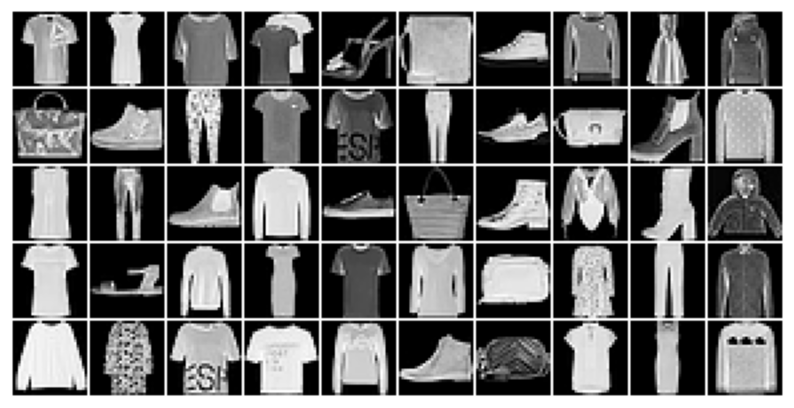

In [33]:
# Generate random indices to select a subset of 50 images from the training set.
# samples = torch.randint(0, len(train_val_set), (50,))
samples = torch.randperm(len(train_val_set))[:50]

# Use the generated indices to select images.
# Stack the selected images and permute dimensions for display.
# Note: `.permute(1,0,2,3)` rearranges the tensor dimensions for grid plotting.
images_selected = torch.stack([train_val_set.data[samples]]).permute(1, 0, 2, 3)

# Print the shape of the selected images tensor to validate its dimensions.
print(images_selected.shape)

# Display the selected images using the custom 'show_images' function.
show_images(images_selected)


# <Font color = 'indianred'>**Model1**

In [34]:
# Display the shape of the 'images' tensor
images_selected.shape

torch.Size([50, 1, 28, 28])

Display the shape of the 'images' tensor.
The dimensions are organized as follows:
> - batch_size: Number of images in the current batch
> - Channels: Number of color channels (e.g., 1 for grayscale, 3 for RGB)
> - Height: Height of each image in pixels
> - Width: Width of each image in pixels


In [35]:
# Flattening the 'images' tensor from the 2nd dimension to the last.
# The resulting shape will be [batch_size, Channels*Height*Width].
torch.flatten(images_selected, start_dim=1, end_dim=-1).shape


torch.Size([50, 784])

In [36]:
nn.Flatten??

In [37]:

def pytorch_mlp(num_features, hidden_dim1, hidden_dim2, num_classes):
    """
    Creates a simple Multilayer Perceptron (MLP) model in PyTorch.

    Parameters:
    - num_features (int): The number of input features.
    - hidden_dim1 (int): The size of the first hidden layer.
    - hidden_dim2 (int): The size of the second hidden layer.
    - num_classes (int): The number of output classes.

    Returns:
    - nn.Sequential: A PyTorch Sequential model representing the MLP.
    """
    model = nn.Sequential(
        # Flatten the input tensor from [batch_size, Channels, Height, Width] to [batch_size, Channels*Height*Width]
        nn.Flatten(start_dim=1, end_dim=-1),

        # First fully connected layer, followed by ReLU activation
        nn.Linear(num_features, hidden_dim1),
        nn.ReLU(),

        # Second fully connected layer, followed by ReLU activation
        nn.Linear(hidden_dim1, hidden_dim2),
        nn.ReLU(),

        # Output layer
        nn.Linear(hidden_dim2, num_classes),
    )
    return model



In [38]:
model1 = pytorch_mlp(784, 200, 100, 10)

In [39]:
model1

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=200, bias=True)
  (2): ReLU()
  (3): Linear(in_features=200, out_features=100, bias=True)
  (4): ReLU()
  (5): Linear(in_features=100, out_features=10, bias=True)
)

In [40]:
summary(model1, (1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Flatten: 1-1                           [1, 784]                  --
├─Linear: 1-2                            [1, 200]                  157,000
├─ReLU: 1-3                              [1, 200]                  --
├─Linear: 1-4                            [1, 100]                  20,100
├─ReLU: 1-5                              [1, 100]                  --
├─Linear: 1-6                            [1, 10]                   1,010
Total params: 178,110
Trainable params: 178,110
Non-trainable params: 0
Total mult-adds (M): 0.18
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.71
Estimated Total Size (MB): 0.72

# <Font color = 'indianred'>**Model2**



In [41]:
class PytorchMLP(nn.Module):
    """
    Custom Multilayer Perceptron (MLP) class that inherits from PyTorch's nn.Module.

    Parameters:
    - num_features (int): The number of input features.
    - hidden_dim1 (int): The size of the first hidden layer.
    - hidden_dim2 (int): The size of the second hidden layer.
    - num_classes (int): The number of output classes.
    """
    def __init__(self, num_features, hidden_dim1, hidden_dim2, num_classes):
        super().__init__()

        # Define the sequence of layers for the MLP , use self as we need to use outside the fn
        self.layers = nn.Sequential(
        # Flatten the input tensor from [batch_size, Channels, Height, Width] to [batch_size, Channels*Height*Width]
        nn.Flatten(start_dim=1, end_dim=-1),

        # First fully connected layer, followed by ReLU activation
        nn.Linear(num_features, hidden_dim1),
        nn.ReLU(),

        # Second fully connected layer, followed by ReLU activation
        nn.Linear(hidden_dim1, hidden_dim2),
        nn.ReLU(),

        # Output layer
        nn.Linear(hidden_dim2, num_classes))

        # code here

    def forward(self, x):
        """
        Forward pass of the network.

        Parameters:
        - x (torch.Tensor): The input tensor.

        Returns:
        - out (torch.Tensor): The output tensor.
        """
        out = self.layers(x)
        return out


In [42]:
model2a=PytorchMLP(784, 200, 100, 10)

In [43]:
model2a

PytorchMLP(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=200, bias=True)
    (2): ReLU()
    (3): Linear(in_features=200, out_features=100, bias=True)
    (4): ReLU()
    (5): Linear(in_features=100, out_features=10, bias=True)
  )
)

In [44]:
summary(model2a, (1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
PytorchMLP                               [1, 10]                   --
├─Sequential: 1-1                        [1, 10]                   --
│    └─Flatten: 2-1                      [1, 784]                  --
│    └─Linear: 2-2                       [1, 200]                  157,000
│    └─ReLU: 2-3                         [1, 200]                  --
│    └─Linear: 2-4                       [1, 100]                  20,100
│    └─ReLU: 2-5                         [1, 100]                  --
│    └─Linear: 2-6                       [1, 10]                   1,010
Total params: 178,110
Trainable params: 178,110
Non-trainable params: 0
Total mult-adds (M): 0.18
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.71
Estimated Total Size (MB): 0.72

<img src ="https://drive.google.com/uc?export=view&id=15fHshFY9Mz9ObaZvUA094UiZrg8DCcTI" width = 200 >

In [45]:
class PytorchMLPSkip(nn.Module):
    """
    Custom Multilayer Perceptron (MLP) with skip connections class that inherits from PyTorch's nn.Module.

    Parameters:
    - num_features (int): The number of input features.
    - hidden_dim1 (int): The size of the first hidden layer.
    - hidden_dim2 (int): The size of the second hidden layer.
    - num_classes (int): The number of output classes.
    """
    def __init__(self, num_features, hidden_dim1, hidden_dim2, num_classes):
        super().__init__()

        # Flatten layer to convert input tensor shape from [batch_size, C, H, W] to [batch_size, C*H*W]
        self.flatten = nn.Flatten()

        # First hidden layer and its activation function
        self.hidden_layer1 = nn.Linear(num_features, hidden_dim1)
        self.layer1_activation = nn.ReLU()

        # Second hidden layer and its activation function
        self.hidden_layer2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.layer2_activation = nn.ReLU()

        # Output layer that combines output from both hidden layers
        self.output_layer = nn.Linear(hidden_dim1 + hidden_dim2, num_classes)

    def forward(self, x):
        """
        Forward pass of the network with skip connection.

        Parameters:
        - x (torch.Tensor): The input tensor.

        Returns:
        - out (torch.Tensor): The output tensor.
        """
        x = self.flatten(x)
        out1 = self.layer1_activation(self.hidden_layer1(x))

        out2 = self.layer2_activation(self.hidden_layer2(out1))

        concat_output = torch.cat((out1, out2), dim=1)

        return self.output_layer(concat_output)







In [46]:
model2b= PytorchMLPSkip(784, 200, 100, 10)

In [47]:
model2b

PytorchMLPSkip(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (hidden_layer1): Linear(in_features=784, out_features=200, bias=True)
  (layer1_activation): ReLU()
  (hidden_layer2): Linear(in_features=200, out_features=100, bias=True)
  (layer2_activation): ReLU()
  (output_layer): Linear(in_features=300, out_features=10, bias=True)
)

In [48]:
summary(model2b, (1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
PytorchMLPSkip                           [1, 10]                   --
├─Flatten: 1-1                           [1, 784]                  --
├─Linear: 1-2                            [1, 200]                  157,000
├─ReLU: 1-3                              [1, 200]                  --
├─Linear: 1-4                            [1, 100]                  20,100
├─ReLU: 1-5                              [1, 100]                  --
├─Linear: 1-6                            [1, 10]                   3,010
Total params: 180,110
Trainable params: 180,110
Non-trainable params: 0
Total mult-adds (M): 0.18
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.72
Estimated Total Size (MB): 0.73

# <Font color = 'indianred'>**Model Training**




To train a machine learning model effectively, we need a structured approach that combines training and evaluation while maintaining flexibility and readability. We break down the training loop into four distinct functions, each serving a specific role. This modular approach enhances code clarity, reusability, and allows for easy modifications. Let's outline our strategy for training and evaluation:

1. **`step` Function**: This is our foundational building block. It handles a single forward and backward step for a batch of data. Whether during training or evaluation, we need to calculate model outputs, compute the loss, and potentially perform backpropagation to update model parameters. By encapsulating these fundamental operations in `step`, we ensure consistency and enable future adjustments with minimal disruption.

  **Model Training** involves five steps:

- Step 1: Compute model's predictions - forward pass (both train and eval)
- Step 2: Compute loss (both train and eval)
- Step 3: Compute the gradients (only train)
- Step 4: Update the parameters (only train)
- Step 5: Repeat steps 1 - 4


2. **`train_epoch` Function**: This function orchestrates training for a single epoch. It iterates through the entire training dataset, invoking `step` for each batch. While doing so, it keeps track of the running training loss and the number of correct predictions. Its primary role is to aggregate statistics for the entire epoch. Additionally, it ensures that the model is in the training mode.

3. **`val_epoch` Function**: Similar to `train_epoch`, this function handles validation. It iterates through the validation dataset, employing `step` for each batch, but crucially, it operates in a context where gradients aren't computed. This no-gradient mode conserves memory and computational resources. Like `train_epoch`, it is responsible for aggregating validation metrics and also ensures that the model is in evaluation mode.

4. **`train` Function**: Our top-level function for training the model. It sets up the training environment for multiple epochs, invoking `train_epoch` for each training epoch and `val_epoch` for each validation epoch. It keeps track of metrics across epochs, making it easier to analyze model performance over time.

By organizing our training and evaluation pipeline in this manner, we achieve code modularity and clarity. Furthermore, this structure allows us to easily swap out components like loss functions, optimizers, or metrics without overhauling the entire codebase. Now, let's dive into the details of each function.

## <Font color = 'indianred'>**Step Function**

In [49]:
def step(inputs, targets, model, device, loss_function=None, optimizer=None):
    """
    Performs a forward and backward pass for a given batch of inputs and targets.

    Parameters:
    - inputs (torch.Tensor): The input data for the model.
    - targets (torch.Tensor): The true labels for the input data.
    - model (torch.nn.Module): The neural network model.
    - device (torch.device): The computing device (CPU or GPU).
    - loss_function (torch.nn.Module, optional): The loss function to use.
    - optimizer (torch.optim.Optimizer, optional): The optimizer to update model parameters.

    Returns:
    - loss (float): The computed loss value (only if loss_function is not None).
    - outputs (torch.Tensor): The predictions from the model.
    - correct (int): The number of correctly classified samples in the batch.
    """
    # Move the model and data to the device
    model = model.to(device)
    inputs = inputs.to(device)
    targets = targets.to(device)

    # Step 1: Forward pass to get the model's predictions
    outputs = model(inputs)

    # Step 2: Compute the loss using the provided loss function
    if loss_function:
        loss = loss_function(outputs, targets)

    # Step 2: Calculate the number of correctly classified samples
    predicted = torch.argmax(outputs.data, 1)
    correct = (predicted == targets).sum().item() # item converge to numpy

    # Step 3 and 4: Perform backward pass and update model parameters if an optimizer is provided
    if optimizer:
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Return relevant metrics
    if loss_function:
        return loss, outputs, correct
    else:
        return outputs, correct


## <Font color = 'indianred'>**Train_Epoch Function**

In [50]:
def train_epoch(train_loader, model, device, loss_function, optimizer):
    """
    Trains the model for one epoch using the provided data loader and updates the model parameters.

    Parameters:
    - train_loader (torch.utils.data.DataLoader): DataLoader object for the training set.
    - model (torch.nn.Module): The neural network model to be trained.
    - device (torch.device): The computing device (CPU or GPU).
    - loss_function (torch.nn.Module): The loss function to use for training.
    - optimizer (torch.optim.Optimizer): The optimizer to update model parameters.

    Returns:
    - train_loss (float): Average training loss for the epoch.
    - train_acc (float): Training accuracy for the epoch.
    """
    # Set the model to training mode
    model.train()

    # Initialize variables to track running training loss and correct predictions
    running_train_loss = 0.0
    running_train_correct = 0

    # Iterate over all batches in the training data
    for inputs, targets in train_loader:
        # Perform a forward and backward pass, updating model parameters
        loss, _, correct = step(inputs, targets, model, device, loss_function, optimizer)

        # Update running loss and correct predictions counter
        running_train_loss += loss.item()
        running_train_correct += correct

    # Compute average loss and accuracy for the entire training set
    train_loss = running_train_loss / len(train_loader) # train_loader len = no of batches
    train_acc = running_train_correct / len(train_loader.dataset) # total no of obs

    return train_loss, train_acc


## <Font color = 'indianred'>**Val_Epoch Function**

In [51]:
def val_epoch(valid_loader, model, device, loss_function):
    """
    Validates the model for one epoch using the provided data loader.

    Parameters:
    - valid_loader (torch.utils.data.DataLoader): DataLoader object for the validation set.
    - model (torch.nn.Module): The neural network model to be validated.
    - device (torch.device): The computing device (CPU or GPU).
    - loss_function (torch.nn.Module): The loss function to evaluate the model.

    Returns:
    - val_loss (float): Average validation loss for the epoch.
    - val_acc (float): Validation accuracy for the epoch.
    """
    # Set the model to evaluation mode
    model.eval()

    # Initialize variables to track running validation loss and correct predictions
    running_val_loss = 0.0
    running_val_correct = 0

    # Disable gradient computation
    with torch.no_grad():
        # Iterate over all batches in the validation data
        for inputs, targets in valid_loader:
            # Perform a forward pass to get loss and number of correct predictions
            loss, _, correct = step(inputs, targets, model, device, loss_function, optimizer=None)

            # Update running loss and correct predictions counter
            running_val_loss += loss.item()
            running_val_correct += correct

    # Compute average loss and accuracy for the entire validation set
    val_loss = running_val_loss / len(valid_loader)
    val_acc = running_val_correct / len(valid_loader.dataset)

    return val_loss, val_acc


## <Font color = 'indianred'>**Train Function**

In [52]:
def train(train_loader, valid_loader, model, optimizer, loss_function, epochs, device):
    """
    Trains and validates the model, and returns history of train and validation metrics.

    Parameters:
    - train_loader (torch.utils.data.DataLoader): DataLoader for the training set.
    - valid_loader (torch.utils.data.DataLoader): DataLoader for the validation set.
    - model (torch.nn.Module): Neural network model to train.
    - optimizer (torch.optim.Optimizer): Optimizer algorithm.
    - loss_function (torch.nn.Module): Loss function to evaluate the model.
    - epochs (int): Number of epochs to train the model.
    - device (torch.device): The computing device (CPU or GPU).

    Returns:
    - train_loss_history (list): History of training loss for each epoch.
    - train_acc_history (list): History of training accuracy for each epoch.
    - valid_loss_history (list): History of validation loss for each epoch.
    - valid_acc_history (list): History of validation accuracy for each epoch.
    """

    # Initialize lists to store metrics for each epoch
    train_loss_history = []
    valid_loss_history = []
    train_acc_history = []
    valid_acc_history = []

    # Loop over the number of specified epochs
    for epoch in range(epochs):
        # Train model on training data and capture metrics
        train_loss, train_acc = train_epoch(
            train_loader, model, device, loss_function, optimizer)

        # Validate model on validation data and capture metrics
        valid_loss, valid_acc = val_epoch(
            valid_loader, model, device, loss_function)

        # Store metrics for this epoch
        train_loss_history.append(train_loss)
        train_acc_history.append(train_acc)
        valid_loss_history.append(valid_loss)
        valid_acc_history.append(valid_acc)

        # Output epoch-level summary
        print(f"Epoch {epoch+1}/{epochs}")
        print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc*100:.2f}%")
        print(f"Valid Loss: {valid_loss:.4f} | Valid Accuracy: {valid_acc*100:.2f}%")
        print()

    return train_loss_history, train_acc_history, valid_loss_history, valid_acc_history


## <Font color = 'indianred'>**Hyperparameters**

In [53]:
# Define the model architecture and training parameters
num_features = 784
hidden_dim1 = 200
hidden_dim2 = 100
num_classes = 10
epochs = 20
learning_rate = 0.03

# Set a random seed for reproducibility
torch.manual_seed(42)

# Create the neural network model
model = PytorchMLPSkip(num_features, hidden_dim1, hidden_dim2, num_classes)

# Define the optimizer for updating model parameters
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# Define the loss function for training
loss_function = nn.CrossEntropyLoss()

# Determine the computing device (CPU or GPU) to use
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

summary(model, (1, 28, 28))


Layer (type:depth-idx)                   Output Shape              Param #
PytorchMLPSkip                           [1, 10]                   --
├─Flatten: 1-1                           [1, 784]                  --
├─Linear: 1-2                            [1, 200]                  157,000
├─ReLU: 1-3                              [1, 200]                  --
├─Linear: 1-4                            [1, 100]                  20,100
├─ReLU: 1-5                              [1, 100]                  --
├─Linear: 1-6                            [1, 10]                   3,010
Total params: 180,110
Trainable params: 180,110
Non-trainable params: 0
Total mult-adds (M): 0.18
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.72
Estimated Total Size (MB): 0.73

## <Font color = 'indianred'>**Sanity Check**
- Check the loss without any training. For Cross entropy the expected value will be log(number of classes)

In [54]:
# Sanity check to verify initial loss
i = 0
expected_loss = np.log(10)  # Theoretical loss for a random model
for input_, targets in train_loader:
    # Move inputs and targets to the specified device
    input_ = input_.to(device)
    targets = targets.to(device)
    model.to(device)
    model.eval()

    # Forward pass
    output = model(input_)

    # Calculate the loss
    loss = loss_function(output, targets)
    print(f'Actual loss: {loss}')

    i += 1
    if i > 2:
        break

print(f'Expected Theoretical loss: {expected_loss}')


Actual loss: 2.368440866470337
Actual loss: 2.3638741970062256
Actual loss: 2.3756754398345947
Expected Theoretical loss: 2.3025850929940455


## <Font color = 'indianred'>**Call Train Function**

In [55]:
# Call the train function to train the model
train_losses, train_acc, valid_losses, valid_acc = train(
    train_loader, valid_loader, model, optimizer, loss_function, epochs, device
)


Epoch 1/20
Train Loss: 0.8298 | Train Accuracy: 73.59%
Valid Loss: 0.5814 | Valid Accuracy: 78.91%

Epoch 2/20
Train Loss: 0.5240 | Train Accuracy: 81.56%
Valid Loss: 0.5042 | Valid Accuracy: 81.88%

Epoch 3/20
Train Loss: 0.4710 | Train Accuracy: 83.30%
Valid Loss: 0.4519 | Valid Accuracy: 84.01%

Epoch 4/20
Train Loss: 0.4434 | Train Accuracy: 84.40%
Valid Loss: 0.4502 | Valid Accuracy: 84.02%

Epoch 5/20
Train Loss: 0.4218 | Train Accuracy: 84.98%
Valid Loss: 0.4273 | Valid Accuracy: 84.60%

Epoch 6/20
Train Loss: 0.4069 | Train Accuracy: 85.54%
Valid Loss: 0.3941 | Valid Accuracy: 85.96%

Epoch 7/20
Train Loss: 0.3933 | Train Accuracy: 86.00%
Valid Loss: 0.3929 | Valid Accuracy: 85.96%

Epoch 8/20
Train Loss: 0.3845 | Train Accuracy: 86.29%
Valid Loss: 0.3853 | Valid Accuracy: 86.24%

Epoch 9/20
Train Loss: 0.3735 | Train Accuracy: 86.69%
Valid Loss: 0.3726 | Valid Accuracy: 86.61%

Epoch 10/20
Train Loss: 0.3642 | Train Accuracy: 87.00%
Valid Loss: 0.3645 | Valid Accuracy: 86.96%


## <Font color = 'indianred'>**Plot Losses Metrics**


In [56]:
def plot_history(train_losses, train_metrics, val_losses=None, val_metrics=None):
    """
    Plot training and validation loss and metrics over epochs.

    Args:
        train_losses (list): List of training losses for each epoch.
        train_metrics (list): List of training metrics (e.g., accuracy) for each epoch.
        val_losses (list, optional): List of validation losses for each epoch.
        val_metrics (list, optional): List of validation metrics for each epoch.

    Returns:
        None
    """
    epochs = range(1, len(train_losses) + 1)

    # Plot training and validation losses
    plt.figure()
    plt.plot(epochs, train_losses, label="Train")
    if val_losses:
        plt.plot(epochs, val_losses, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    # Plot training and validation metrics (if available)
    if train_metrics[0] is not None:
        plt.figure()
        plt.plot(epochs, train_metrics, label="Train")
        if val_metrics:
            plt.plot(epochs, val_metrics, label="Validation")
        plt.xlabel("Epochs")
        plt.ylabel("Metric")
        plt.legend()
        plt.show()


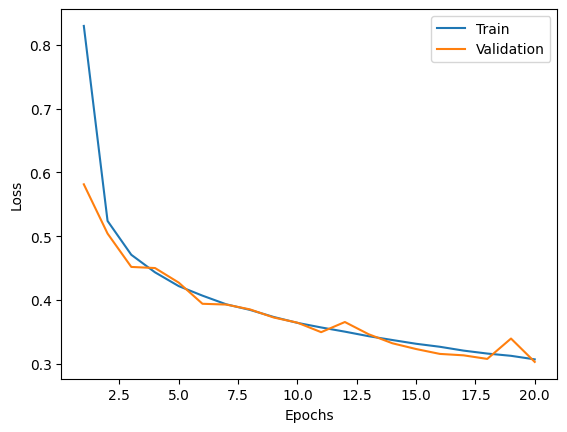

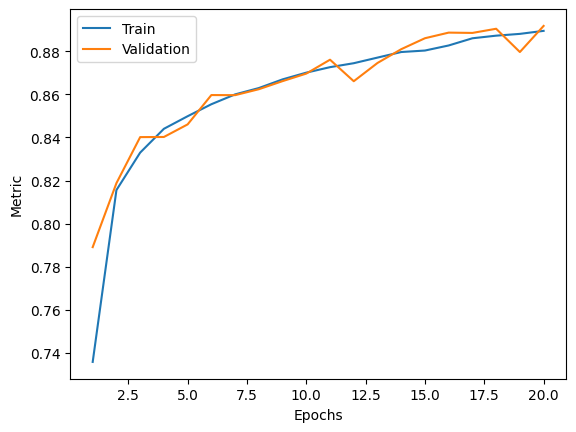

In [57]:
plot_history(train_losses, train_acc, valid_losses, valid_acc)

# <Font color = 'indianred'>**Model Checkpointing**

In [58]:
# Get the current timestamp in the format "YYYY-MM-DD_HH-MM-SS"
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# Define a suffix for the file name
suffix = 'twolayer_skip'

# Combine the timestamp and suffix to create the file path
path = model_folder / f'{timestamp}_{suffix}.pt'


In [59]:
# Save the model's state dictionary to the specified file path
torch.save(model.state_dict(), path)


In [60]:
# Create an instance of the model with the same architecture
my_model = PytorchMLPSkip(num_features, hidden_dim1, hidden_dim2, num_classes)

# Load the model's state dictionary from the specified checkpoint file
checkpoint = torch.load(path)

# Load the saved state dictionary into the model
my_model.load_state_dict(checkpoint)


<All keys matched successfully>

# <Font color = 'indianred'>**Get Accuracy, Predictions**

In [61]:
def get_acc_pred(data_loader, model, device):
    """
    Function to get predictions and accuracy for a given data using a trained model
    Input: data iterator, model, device
    Output: predictions and accuracy for the given dataset
    """
    model = model.to(device)
    # Set model to evaluation mode
    model.eval()

    # Create empty tensors to store predictions and actual labels
    predictions = torch.Tensor().to(device)
    y = torch.Tensor().to(device)

    # Iterate over batches from data iterator
    with torch.no_grad():
        for inputs, targets in data_loader:
            # Process the batch to get the loss, outputs, and correct predictions
            outputs, _ = step(inputs, targets, model,
                              device, loss_function=None, optimizer=None)

            # Choose the label with maximum probability
            _, predicted = torch.max(outputs.data, 1)

            # Add the predicted labels and actual labels to their respective tensors
            predictions = torch.cat((predictions, predicted))
            y = torch.cat((y, targets.to(device)))

    # Calculate accuracy by comparing the predicted and actual labels
    accuracy = (predictions == y).float().mean()

    # Return tuple containing predictions and accuracy
    return predictions, accuracy

In [62]:
# Get the prediction and accuracy
predictions_test, acc_test = get_acc_pred(test_loader, my_model, device)
predictions_train, acc_train = get_acc_pred(train_loader, my_model, device)
predictions_valid, acc_valid = get_acc_pred(valid_loader, my_model, device)

In [63]:
# Print Test Accuracy
print('Test accuracy', acc_test * 100)
print('Train accuracy', acc_train * 100)
print('Valid accuracy', acc_valid * 100)

Test accuracy tensor(86.7500, device='cuda:0')
Train accuracy tensor(89.1708, device='cuda:0')
Valid accuracy tensor(89.1708, device='cuda:0')


# <Font color = 'indianred'>**Confusion Matrix for Test Data**

Now, we will make some visualizations for the predictions that we obtained.

We will construct a `confusion matrix` which will help us to visualize the performance of our classification model on the test dataset as we know the true values for the test data.

In [64]:
# Define the human-readable class labels corresponding to the numerical class indices
classes = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
           'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']

# Get an array containing actual labels from the testing dataset
testing_labels = np.array(testset.targets)

# Compute the confusion matrix between actual labels and predicted labels
cm = confusion_matrix(testing_labels, predictions_test.cpu())

# Create a ConfusionMatrixDisplay object for visualization with class labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)


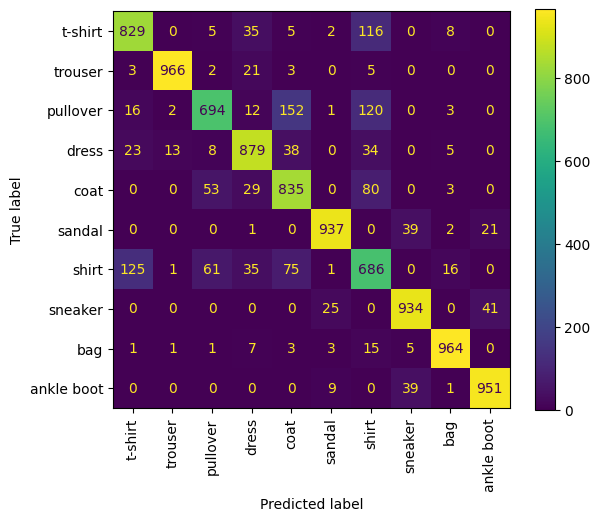

In [65]:
# Create the confusion matrix plot
ax = disp.plot().ax_

# Rotate x-axis labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

# Access the Matplotlib figure from the Axes object and set its size

# Get the current figure
fig = plt.gcf()

# Remove the last (existing) color bar
plt.delaxes(fig.axes[-1])
ax.figure.set_size_inches(8, 8)

# Modify the colorbar size
ax.figure.colorbar(ax.images[0], ax=ax, shrink=0.65)  # 'shrink' parameter adjusts the size

plt.show()